# Imports

In [1]:
import pandas as pd
from sqlalchemy import create_engine, Table, Column, String, MetaData, select
from sqlalchemy.orm import sessionmaker
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from fpdf import FPDF
import os
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import pandas as pd
import time
from memory_profiler import memory_usage
import gc

# Database

In [2]:
def create_db_engine():
    """
    Creates a SQLAlchemy engine with hardcoded credentials.
    
    Returns:
        engine: An SQLAlchemy Engine instance.
    """
    user = 'root'
    password = '2452002Az)'  # Be cautious with sensitive info in production environments
    host = 'localhost'
    database = 'CapstoneTest'
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'
    engine = create_engine(url, echo=True)  # Set echo=False in production for less verbosity
    return engine

def fetch_data_from_db_for_models():
    engine = create_db_engine()
    connection = engine.connect()

    query = """
    SELECT 
        oracle_data.operating_unit_name,
        oracle_data.ecom_reference_order_number,
        oracle_data.ordered_item,
        oracle_data.ordered_quantity,
        oracle_data.unit_selling_price,
        oracle_data.unit_list_price,
        oracle_data.ordered_date,
        oracle_data.tax_code,
        oracle_data_product_name.product_id,
        oracle_data_product_name.product_name,
        oracle_data_product_name.product_category
    FROM 
        oracle_data
    JOIN 
        oracle_data_product_name 
    ON 
        oracle_data.ordered_item = oracle_data_product_name.product_id;
    """

    result = connection.execute(query)
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

    connection.close()
    return df

In [3]:
# Create an engine instance
engine = create_db_engine()

In [4]:
df = fetch_data_from_db_for_models()

2024-08-21 18:21:49,731 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-08-21 18:21:49,733 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-08-21 18:21:49,735 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-08-21 18:21:49,736 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-08-21 18:21:49,738 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-08-21 18:21:49,738 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-08-21 18:21:49,741 INFO sqlalchemy.engine.Engine 
    SELECT 
        oracle_data.operating_unit_name,
        oracle_data.ecom_reference_order_number,
        oracle_data.ordered_item,
        oracle_data.ordered_quantity,
        oracle_data.unit_selling_price,
        oracle_data.unit_list_price,
        oracle_data.ordered_date,
        oracle_data.tax_code,
        oracle_data_product_name.product_id,
        oracle_data_product_name.product_name,
        oracle_data_product_name.product_category
    FROM 
        oracle_data
    JOIN 
        oracle_da

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14716\1030535722.py:41: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  result = connection.execute(query)


In [5]:
df.head()

,operating_unit_name,ecom_reference_order_number,ordered_item,ordered_quantity,unit_selling_price,unit_list_price,ordered_date,tax_code,product_id,product_name,product_category
0,Ch. Sarraf BU FMCG,400522,1102,1,1.3820,1.5405,2024-03-02,REVENUE VAT FMCG 11%,1102,koleston naturals light ash blonde 8,['Permanent']
1,Ch. Sarraf BU FMCG,396929,1102,1,1.5405,1.5405,2024-01-23,REVENUE VAT FMCG 11%,1102,koleston naturals light ash blonde 8,['Permanent']
2,Ch. Sarraf BU FMCG,397809,1102,1,1.4400,1.5405,2024-01-31,REVENUE VAT FMCG 11%,1102,koleston naturals light ash blonde 8,['Permanent']
3,Ch. Sarraf BU FMCG,400876,1103,1,1.3400,1.5405,2024-03-06,REVENUE VAT FMCG 11%,1103,koleston naturals hazelnut 7,['Permanent']
4,Ch. Sarraf BU FMCG,398372,1103,1,1.2980,1.5405,2024-02-15,REVENUE VAT FMCG 11%,1103,koleston naturals hazelnut 7,['Permanent']


# Write to csv (if needed)

In [17]:
df.to_csv("C:\\Users\\Lenovo\\AIRFLOW_DOCKER_1\\streamlit\\capstoneStreamlitApp\\data.csv")

# Preprocessing

In [6]:
def convert_strings_to_lists(df):
    df['product_category'] = df['product_category'].apply(lambda x: ast.literal_eval(x))
    return df

def remove_product_not_found(df):
    df = df[df['product_name'] != 'Product Not Found']
    return df

def preprocess_category_list(category_list):
    return [re.sub(r'[.\(\)]', '', category) for category in category_list]

def apply_preprocess_category_list(df):
    df['product_category'] = df['product_category'].apply(preprocess_category_list)
    return df

def convert_lists_to_strings(df):
    df['product_category'] = df['product_category'].apply(lambda x: ', '.join(x) if x else 'Unknown')
    return df

def remove_higher_selling_price(df):
    df = df[df['unit_selling_price'] <= df['unit_list_price']]
    return df

def calculate_total_sales(df):
    df['total_sales_with_discount'] = df['ordered_quantity'] * df['unit_selling_price']
    df['total_sales_without_discount'] = df['ordered_quantity'] * df['unit_list_price']
    return df

def calculate_discount_percentage(df, unit_list_price_col, unit_selling_price_col, new_col_name='discount_percentage'):
    df[new_col_name] = (df[unit_list_price_col] - df[unit_selling_price_col]) / df[unit_list_price_col] * 100
    return df

def expand_column_to_rows(df, column_to_expand, delimiter=', ', new_col_name=None):
    if new_col_name is None:
        new_col_name = column_to_expand

    df_expanded = df.assign(**{new_col_name: df[column_to_expand].str.split(delimiter)}).explode(new_col_name)
    return df_expanded

def create_relevant_columns_df(df):
    df = df[['ecom_reference_order_number', 'product_name']]
    return df

def remove_shipping_local(df):
    df = df[df['product_name'] != 'SHIPPING_LOCAL']
    return df

def sanitize_column_names(df):
    """
    Rename DataFrame columns to be valid SQL identifiers by replacing spaces and special characters with underscores.
    """
    df.columns = [col.replace(' ', '_').replace('.', '').lower() for col in df.columns]
    return df

def handle_inf_values(df):
    """
    Replaces inf and -inf values with NaN, and then replaces NaN with 0 in the DataFrame.

    Parameters:
    df (DataFrame): The DataFrame to process.

    Returns:
    DataFrame: The processed DataFrame with inf and NaN values handled.
    """
    # Replace inf and -inf with NaN
    df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
    # Replace NaN with 0
    df.fillna(0, inplace=True)
    return df
    
def round_float_columns(df, decimal_places=3):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].round(decimal_places)
    return df

def preprocessing_pipeline_for_report(df):
    df = convert_strings_to_lists(df)
    df = remove_product_not_found(df)
    df = apply_preprocess_category_list(df)
    df = convert_lists_to_strings(df)
    df = remove_higher_selling_price(df)
    df = calculate_total_sales(df)
    df = calculate_discount_percentage(df, 'unit_list_price', 'unit_selling_price')
    return df

def preprocessing_pipeline_for_report_2(df):
    df = create_relevant_columns_df(df)
    df = remove_shipping_local(df)
    return df

In [7]:
df = preprocessing_pipeline_for_report(df)
df_expanded = expand_column_to_rows(df, 'product_category')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14716\2866941276.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_category'] = df['product_category'].apply(preprocess_category_list)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14716\2866941276.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_category'] = df['product_category'].apply(lambda x: ', '.join(x) if x else 'Unknown')


# Write to parquet

In [75]:
df.to_parquet("C:\\Users\\Lenovo\\Desktop\\Final_Model_results\\data_for_model.parquet")

In [8]:
df_expanded.to_parquet("C:\\Users\\Lenovo\\AIRFLOW_DOCKER_1\\streamlit\\data\\data_expanded_for_model.parquet")

# EDA

## Summary statistic

In [9]:
def save_summary_statistics(df, file_path):
    summary_stats = df[['ordered_quantity', 'unit_selling_price', 'unit_list_price']].describe()
    with open(file_path, 'w') as f:
        f.write("Summary Statistics for Numerical Columns:\n")
        f.write(summary_stats.to_string())
    print(f"Summary statistics saved to {file_path}")

save_summary_statistics(df, "C:\\Users\\Lenovo\\Desktop\\report_trial\\summary_statistics.txt")

Summary statistics saved to C:\Users\Lenovo\Desktop\report_trial\summary_statistics.txt


In [10]:
def save_categorical_distribution(df, column_name, file_path):
    categorical_dist = df[column_name].value_counts()
    with open(file_path, 'w') as f:
        f.write(f"Distribution of {column_name}:\n")
        f.write(categorical_dist.to_string())
    print(f"Categorical distribution saved to {file_path}")

save_categorical_distribution(df, 'operating_unit_name', 'C:\\Users\\Lenovo\\Desktop\\report_trial\\operating_unit_name_distribution.txt')


Categorical distribution saved to C:\Users\Lenovo\Desktop\report_trial\operating_unit_name_distribution.txt


In [11]:
def save_unique_categories_info(df, column_name, file_path):
    # Split the comma-separated strings into individual categories and create a set of unique categories
    unique_categories = set()
    df[column_name].apply(lambda x: unique_categories.update(x.split(', ')))

    # Count the number of unique categories
    num_unique_categories = len(unique_categories)
    
    # Save the results to a text file
    with open(file_path, 'w') as f:
        f.write(f"Number of unique categories: {num_unique_categories}\n")
        f.write(f"Unique categories: {unique_categories}\n")
    
    print(f"Unique categories information saved to {file_path}")

save_unique_categories_info(df, 'product_category', 'C:\\Users\\Lenovo\\Desktop\\report_trial\\unique_categories_info.txt')


Unique categories information saved to C:\Users\Lenovo\Desktop\report_trial\unique_categories_info.txt


## Sales Analysis

### Top 10 Best Selling Products

In [12]:
def plot_top_products(df, file_path):
    # Filter out "Product Not Found" and calculate the top 10 best-selling products
    top_products = df[df['product_name'] != 'Product Not Found']\
                    .groupby('product_name')['ordered_quantity']\
                    .sum().sort_values(ascending=False).head(10)
    
    # Plot the top 10 best-selling products
    plt.figure(figsize=(12, 6))
    top_products.plot(kind='bar')
    plt.title('Top 10 Best-Selling Products (Excluding "Product Not Found")')
    plt.xlabel('Product Name')
    plt.ylabel('Total Quantity Sold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
    plt.savefig(file_path)
    plt.close()
    print(f"Top products plot saved to {file_path}")

# Example usage:
plot_top_products(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\top_products.png')


Top products plot saved to C:\Users\Lenovo\Desktop\report_trial\top_products.png


### Monthly Sales Trend

In [13]:
def plot_monthly_sales_trend(df, file_path):
    # Extract month and year from ordered_date
    df['year_month'] = df['ordered_date'].dt.to_period('M')

    # Aggregate sales by month
    monthly_sales = df.groupby('year_month')['total_sales_with_discount'].sum()

    # Convert the year_month to a string format for better readability
    monthly_sales.index = monthly_sales.index.strftime('%B %Y')

    # Plot the monthly sales trend as a horizontal bar chart
    plt.figure(figsize=(12, 6))
    monthly_sales.plot(kind='barh')
    plt.title('Bar Chart of Monthly Sales')
    plt.xlabel('Total Sales with Discount')
    plt.ylabel('Month')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
    plt.savefig(file_path)
    plt.close()
    print(f"Monthly sales trend plot saved to {file_path}")

# Example usage:
plot_monthly_sales_trend(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\monthly_sales_trend.png')


Monthly sales trend plot saved to C:\Users\Lenovo\Desktop\report_trial\monthly_sales_trend.png


### Revenue Contribution by Product Category

In [14]:
# def get_top_categories(df, file_path):
#     # Group by product_category and sum the ordered_quantity
#     category_quantity = df.groupby('product_category')['ordered_quantity'].sum().reset_index()

#     # Sort the categories by total quantity sold and select the top 10
#     top_categories = category_quantity.sort_values(by='ordered_quantity', ascending=False).head(10)

#     # Save the top categories to a text file
#     with open(file_path, 'w') as f:
#         f.write("Top 10 Best-Selling Product Categories:\n")
#         f.write(top_categories.to_string(index=False))
#     print(f"Top categories information saved to {file_path}")

# get_top_categories(df_expanded, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\top_categories.txt')

import pandas as pd

def get_top_categories(df, file_path):
    # Group by product_category and sum the ordered_quantity
    category_quantity = df.groupby('product_category')['ordered_quantity'].sum().reset_index()

    # Sort the categories by total quantity sold and select the top 10
    top_categories = category_quantity.sort_values(by='ordered_quantity', ascending=False).head(10)

    # Save the top categories to a CSV file
    top_categories.to_csv(file_path, index=False)
    print(f"Top categories information saved to {file_path}")

# Example usage
get_top_categories(df_expanded, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\top_categories.csv')


Top categories information saved to C:\Users\Lenovo\Desktop\report_trial\top_categories.csv


### total sales by product category

In [15]:
def plot_category_sales(df, file_path):
    # Calculate total sales by product category
    category_sales = df_expanded.groupby('product_category')['total_sales_with_discount'].sum().sort_values(ascending=False)

    # Plot the revenue contribution by product category
    plt.figure(figsize=(12, 6))
    category_sales.plot(kind='bar')
    plt.title('Revenue Contribution by Product Category')
    plt.xlabel('Product Category')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
    plt.savefig(file_path)
    plt.close()
    print(f"Category sales plot saved to {file_path}")

# Example usage:
plot_category_sales(df_expanded, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\category_sales.png')


Category sales plot saved to C:\Users\Lenovo\Desktop\report_trial\category_sales.png


### Order Quantity Distribution

In [16]:
def plot_order_quantity_distribution(df, file_path):
    # Plot distribution of order quantities
    plt.figure(figsize=(12, 6))
    df['ordered_quantity'].plot(kind='hist', bins=30)
    plt.title('Distribution of Order Quantities')
    plt.xlabel('Order Quantity')
    plt.ylabel('Frequency')

    # Set the x-axis ticks with increments of 5
    max_order_quantity = df['ordered_quantity'].max()
    plt.xticks(range(0, max_order_quantity + 1, 5))

    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Order quantity distribution plot saved to {file_path}")

# Example usage:
plot_order_quantity_distribution(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\order_quantity_distribution.png')


Order quantity distribution plot saved to C:\Users\Lenovo\Desktop\report_trial\order_quantity_distribution.png


### Monetary Distribution

In [17]:
def plot_monetary_distribution(df, file_path):
    # Calculate Monetary Value
    monetary = df.groupby('ecom_reference_order_number')['total_sales_with_discount'].sum()
    rfm = pd.DataFrame({'monetary': monetary})

    # Plot the Monetary Distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(rfm, x='monetary', kde=True)
    plt.title('Monetary Distribution')
    plt.xlabel('Total Spend')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Monetary distribution plot saved to {file_path}")

# Example usage:
plot_monetary_distribution(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\monetary_distribution.png')


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Monetary distribution plot saved to C:\Users\Lenovo\Desktop\report_trial\monetary_distribution.png


## Order Analysis

### Recency Distribution

In [18]:
def plot_recency_distribution(df, file_path):
    # Calculate Recency
    df['recency'] = (df['ordered_date'].max() - df['ordered_date']).dt.days

    rfm = pd.DataFrame({
        'recency': df.groupby('ecom_reference_order_number')['recency'].min()
    })

    # Plot Recency Distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(rfm, x='recency', kde=True)
    plt.title('Recency Distribution')
    plt.xlabel('Days Since Last Purchase')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Recency distribution plot saved to {file_path}")

# Example usage:
plot_recency_distribution(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\recency_distribution.png')


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Recency distribution plot saved to C:\Users\Lenovo\Desktop\report_trial\recency_distribution.png


### Distribution of Items per Order

In [40]:
# def save_order_quantity_stats(df, file_path):
#     # Group by ecom_reference_order_number and calculate the sum of ordered_quantity for each order
#     order_quantity_stats = df.groupby('ecom_reference_order_number')['ordered_quantity'].sum()

#     # Calculate summary statistics
#     summary_stats = order_quantity_stats.describe()

#     # Extract the specific statistics
#     average_items_per_order = summary_stats['mean']
#     min_items_per_order = summary_stats['min']
#     max_items_per_order = summary_stats['max']
#     q1_items_per_order = summary_stats['25%']
#     median_items_per_order = summary_stats['50%']
#     q3_items_per_order = summary_stats['75%']

#     # Save the results to a text file
#     with open(file_path, 'w') as f:
#         f.write(f'Average number of items per order: {average_items_per_order}\n')
#         f.write(f'Minimum number of items per order: {min_items_per_order}\n')
#         f.write(f'Maximum number of items per order: {max_items_per_order}\n')
#         f.write(f'Q1 (25th percentile) number of items per order: {q1_items_per_order}\n')
#         f.write(f'Median (50th percentile) number of items per order: {median_items_per_order}\n')
#         f.write(f'Q3 (75th percentile) number of items per order: {q3_items_per_order}\n')

#     print(f"Order quantity statistics saved to {file_path}")

# # Example usage:
# save_order_quantity_stats(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\order_quantity_stats.txt')


def save_order_quantity_stats(df, file_path):
    # Group by ecom_reference_order_number and calculate the sum of ordered_quantity for each order
    order_quantity_stats = df.groupby('ecom_reference_order_number')['ordered_quantity'].sum()

    # Calculate summary statistics
    summary_stats = order_quantity_stats.describe()

    # Extract the specific statistics and create a DataFrame
    stats = {
        'Statistic': ['Average', 'Minimum', 'Maximum', 'Q1 (25th percentile)', 'Median (50th percentile)', 'Q3 (75th percentile)'],
        'Value': [
            summary_stats['mean'],
            summary_stats['min'],
            summary_stats['max'],
            summary_stats['25%'],
            summary_stats['50%'],
            summary_stats['75%']
        ]
    }
    stats_df = pd.DataFrame(stats)

    # Save the results to a CSV file
    stats_df.to_csv(file_path, index=False)
    print(f"Order quantity statistics saved to {file_path}")

# Example usage:
save_order_quantity_stats(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\order_quantity_stats.csv')



Order quantity statistics saved to C:\Users\Lenovo\Desktop\report_trial\order_quantity_stats.csv


In [20]:
def plot_items_per_order_distribution(df, file_path):
    # Group by ecom_reference_order_number and calculate the sum of ordered_quantity for each order
    order_quantity_stats = df.groupby('ecom_reference_order_number')['ordered_quantity'].sum()

    # Plotting the histogram
    plt.figure(figsize=(12, 6))
    order_quantity_stats.plot(kind='hist', bins=30, alpha=0.7)
    plt.title('Distribution of Items per Order')
    plt.xlabel('Number of Items per Order')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Items per order distribution plot saved to {file_path}")

# Example usage:
plot_items_per_order_distribution(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\items_per_order_distribution.png')


Items per order distribution plot saved to C:\Users\Lenovo\Desktop\report_trial\items_per_order_distribution.png


## Pricing and Discount Analysis

### Distribution of Selling Prices and List Prices

In [21]:
def plot_price_distribution(df, file_path):
    # Plot distribution of unit selling prices and unit list prices
    plt.figure(figsize=(12, 6))
    df['unit_selling_price'].plot(kind='hist', bins=20, alpha=0.5, label='Selling Price')
    df['unit_list_price'].plot(kind='hist', bins=20, alpha=0.5, label='List Price')
    plt.title('Distribution of Selling Prices and List Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Price distribution plot saved to {file_path}")

# Example usage:
plot_price_distribution(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\price_distribution.png')


Price distribution plot saved to C:\Users\Lenovo\Desktop\report_trial\price_distribution.png


### Distribution of Discount Percentages

In [22]:
def plot_discount_percentage_distribution(df, file_path):
    # Calculate discount percentage
    df['discount_percentage'] = (df['unit_list_price'] - df['unit_selling_price']) / df['unit_list_price'] * 100

    # Plot the distribution of discount percentages
    plt.figure(figsize=(12, 6))
    df['discount_percentage'].plot(kind='hist', bins=20)
    plt.title('Distribution of Discount Percentages')
    plt.xlabel('Discount Percentage')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Discount percentage distribution plot saved to {file_path}")

# Example usage:
plot_discount_percentage_distribution(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\discount_percentage_distribution.png')


Discount percentage distribution plot saved to C:\Users\Lenovo\Desktop\report_trial\discount_percentage_distribution.png


### Box Plot of Discount Percentages by Product Category

In [23]:
def plot_discount_percentage_by_category(df_expanded, file_path):
    # Calculate the total sales per category
    category_quantity = df_expanded.groupby('product_category')['ordered_quantity'].sum().reset_index()

    # Sort the categories by total sales
    sorted_categories = category_quantity.sort_values(by='ordered_quantity', ascending=False)['product_category']

    # Convert product_category to a categorical type with the sorted order
    df_expanded['product_category'] = pd.Categorical(df_expanded['product_category'], categories=sorted_categories, ordered=True)

    # Plot the box plot with sorted categories
    plt.figure(figsize=(15, 8))  # Increase figure width
    sns.boxplot(x='product_category', y='discount_percentage', data=df_expanded, width=0.5)
    plt.title('Box Plot of Discount Percentages by Product Category')
    plt.xlabel('Product Category')
    plt.ylabel('Discount Percentage')
    plt.xticks(rotation=90, ha='right')  # Rotate labels more and align to the right
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.savefig(file_path)
    plt.close()
    print(f"Discount percentages by category box plot saved to {file_path}")

# Example usage:
plot_discount_percentage_by_category(df_expanded, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\discount_percentage_by_category.png')


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Discount percentages by category box plot saved to C:\Users\Lenovo\Desktop\report_trial\discount_percentage_by_category.png


### Scatter Plot of Discount Percentage vs. Ordered Quantity

In [24]:
def plot_discount_vs_ordered_quantity(df, file_path):
    # Calculate the correlation
    correlation = df['discount_percentage'].corr(df['ordered_quantity'])

    # Scatter plot of discount percentage vs. ordered quantity
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='discount_percentage', y='ordered_quantity', data=df, alpha=0.6)
    plt.title('Scatter Plot of Discount Percentage vs. Ordered Quantity')
    plt.xlabel('Discount Percentage')
    plt.ylabel('Ordered Quantity')
    plt.grid(True)

    # Add the correlation value to the plot
    plt.text(0.05, max(df['ordered_quantity']) * 0.95, f'Correlation: {correlation:.2f}', fontsize=12, color='red')

    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Scatter plot of discount percentage vs. ordered quantity saved to {file_path}")

# Example usage:
plot_discount_vs_ordered_quantity(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\discount_vs_ordered_quantity.png')


Scatter plot of discount percentage vs. ordered quantity saved to C:\Users\Lenovo\Desktop\report_trial\discount_vs_ordered_quantity.png


### Comparison of Average Discounts for Popular and Less Popular Items

In [25]:
def plot_average_discounts_comparison_hist(df, file_path_hist):
    # Calculate total quantity ordered for each item
    item_popularity = df.groupby('product_name')['ordered_quantity'].sum()

    # Determine the median popularity
    median_popularity = item_popularity.median()

    # Categorize items into popular and less popular
    df['popularity'] = df['product_name'].map(lambda x: 'Popular' if item_popularity[x] > median_popularity else 'Less Popular')

    # Calculate the average discount percentage for each item
    average_discounts = df.groupby('product_name')['discount_percentage'].mean()
    df['average_discount'] = df['product_name'].map(average_discounts)

    # Create a DataFrame for comparison
    comparison_df = df[['product_name', 'popularity', 'average_discount']].drop_duplicates()

    # Histogram to compare average discounts
    plt.figure(figsize=(12, 6))
    sns.histplot(data=comparison_df, x='average_discount', hue='popularity', element='step', stat='density', common_norm=False, bins=20)
    plt.title('Comparison of Average Discounts for Popular and Less Popular Items')
    plt.xlabel('Average Discount Percentage')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.savefig(file_path_hist)
    plt.close()
    print(f"Histogram of average discounts comparison saved to {file_path_hist}")

def save_average_discounts_summary_stats(df, file_path_stats):
    # Calculate total quantity ordered for each item
    item_popularity = df.groupby('product_name')['ordered_quantity'].sum()

    # Determine the median popularity
    median_popularity = item_popularity.median()

    # Categorize items into popular and less popular
    df['popularity'] = df['product_name'].map(lambda x: 'Popular' if item_popularity[x] > median_popularity else 'Less Popular')

    # Calculate the average discount percentage for each item
    average_discounts = df.groupby('product_name')['discount_percentage'].mean()
    df['average_discount'] = df['product_name'].map(average_discounts)

    # Create a DataFrame for comparison
    comparison_df = df[['product_name', 'popularity', 'average_discount']].drop_duplicates()

    # Print summary statistics for further insight
    summary_stats = comparison_df.groupby('popularity')['average_discount'].describe()
    with open(file_path_stats, 'w') as f:
        f.write(summary_stats.to_string())
    print(f"Summary statistics saved to {file_path_stats}")

# Example usage:
plot_average_discounts_comparison_hist(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\average_discounts_comparison_hist.png')
save_average_discounts_summary_stats(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\average_discounts_summary_stats.txt')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Histogram of average discounts comparison saved to C:\Users\Lenovo\Desktop\report_trial\average_discounts_comparison_hist.png
Summary statistics saved to C:\Users\Lenovo\Desktop\report_trial\average_discounts_summary_stats.txt


### Box Plot of Unit Selling Prices by Top Performing Product Categories

In [26]:
def plot_top_categories_unit_selling_prices(df_expanded, file_path):
    # Calculate total sales for each category
    df_expanded['total_sales_with_discount'] = df_expanded['ordered_quantity'] * df_expanded['unit_selling_price']
    category_sales = df_expanded.groupby('product_category')['total_sales_with_discount'].sum()

    # Identify top performing categories
    top_categories = category_sales.sort_values(ascending=False).head(10).index.tolist()

    # Filter DataFrame to include only top performing categories
    top_categories_df = df_expanded[df_expanded['product_category'].isin(top_categories)]

    # Plot the box plot for top performing categories with specified order
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='product_category', y='unit_selling_price', data=top_categories_df, order=top_categories)
    plt.title('Box Plot of Unit Selling Prices by Top Performing Product Categories')
    plt.xlabel('Product Category')
    plt.ylabel('Unit Selling Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Box plot of unit selling prices by top performing product categories saved to {file_path}")

# Example usage:
plot_top_categories_unit_selling_prices(df_expanded, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\top_categories_unit_selling_prices.png')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22012\4060591382.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales = df_expanded.groupby('product_category')['total_sales_with_discount'].sum()
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Box plot of unit selling prices by top performing product categories saved to C:\Users\Lenovo\Desktop\report_trial\top_categories_unit_selling_prices.png


## Supply Chain Analysis

### Top Distributing Companies by Quantity Shipped

In [27]:
def plot_top_distributors_treemap(df, file_path):
    # Top distributing companies
    top_distributors = df.groupby('operating_unit_name')['ordered_quantity'].sum().sort_values(ascending=False).head(10)

    # Create a list of colors in shades of blue and reverse it
    colors = plt.cm.Blues(range(0, 256, int(256/len(top_distributors))))
    colors = colors[::-1]  # Reverse the colors

    # Create a treemap
    plt.figure(figsize=(12, 6))
    squarify.plot(sizes=top_distributors.values, label=top_distributors.index, alpha=0.8, color=colors)
    plt.title('Top Distributing Companies by Quantity Shipped')
    plt.axis('off')  # Remove axes
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Treemap of top distributing companies saved to {file_path}")

# Example usage:
plot_top_distributors_treemap(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\top_distributors_treemap.png')

Treemap of top distributing companies saved to C:\Users\Lenovo\Desktop\report_trial\top_distributors_treemap.png


## Product Positionning

### Distribution of the Number of Items per Transaction

In [28]:
def plot_transaction_diversity(df, file_path):
    # Create a basket matrix (binary matrix)
    basket = (df
              .groupby(['ecom_reference_order_number', 'product_name'])['product_name']
              .count().unstack().reset_index().fillna(0)
              .set_index('ecom_reference_order_number'))
    basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

    # Count the number of unique items per transaction
    unique_items_per_transaction = basket_sets.sum(axis=1)

    # Plot the distribution of the number of items per transaction
    plt.figure(figsize=(10, 6))
    plt.hist(unique_items_per_transaction, bins=range(1, unique_items_per_transaction.max() + 1), edgecolor='k')
    plt.title('Distribution of the Number of Items per Transaction')
    plt.xlabel('Number of Items per Transaction')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Distribution of the number of items per transaction plot saved to {file_path}")

# Example usage:
plot_transaction_diversity(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\transaction_diversity.png')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22012\1486493985.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)


Distribution of the number of items per transaction plot saved to C:\Users\Lenovo\Desktop\report_trial\transaction_diversity.png


### Distribution of Item Frequencies

In [29]:
def plot_item_frequencies(df, file_path):
    # Create a basket matrix (binary matrix)
    basket = (df
              .groupby(['ecom_reference_order_number', 'product_name'])['product_name']
              .count().unstack().reset_index().fillna(0)
              .set_index('ecom_reference_order_number'))
    basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

    # Count the frequency of each item across all transactions
    item_frequencies = basket_sets.sum(axis=0)

    # Plot the distribution of item frequencies
    plt.figure(figsize=(10, 6))
    plt.hist(item_frequencies, bins=range(1, item_frequencies.max() + 1), edgecolor='k')
    plt.title('Distribution of Item Frequencies')
    plt.xlabel('Frequency of Items')
    plt.ylabel('Number of Items')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Distribution of item frequencies plot saved to {file_path}")

# Example usage:
plot_item_frequencies(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\item_frequencies.png')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22012\2757210640.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)


Distribution of item frequencies plot saved to C:\Users\Lenovo\Desktop\report_trial\item_frequencies.png


### Transaction diversity statistics

In [41]:
# def save_transaction_diversity_stats(df, file_path):
#     # Create a basket matrix (binary matrix)
#     basket = (df
#               .groupby(['ecom_reference_order_number', 'product_name'])['product_name']
#               .count().unstack().reset_index().fillna(0)
#               .set_index('ecom_reference_order_number'))
#     basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

#     # Count the number of unique items per transaction
#     unique_items_per_transaction = basket_sets.sum(axis=1)

#     # Save basic statistics to a text file
#     with open(file_path, 'w') as f:
#         f.write("Transaction Diversity:\n")
#         f.write(unique_items_per_transaction.describe().to_string())
#     print(f"Transaction diversity statistics saved to {file_path}")

# # Example usage:
# save_transaction_diversity_stats(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\transaction_diversity_stats.txt')

import pandas as pd

def save_transaction_diversity_stats(df, file_path):
    # Create a basket matrix (binary matrix)
    basket = (df
              .groupby(['ecom_reference_order_number', 'product_name'])['product_name']
              .count().unstack().reset_index().fillna(0)
              .set_index('ecom_reference_order_number'))
    basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

    # Count the number of unique items per transaction
    unique_items_per_transaction = basket_sets.sum(axis=1)

    # Calculate basic statistics
    stats = unique_items_per_transaction.describe()

    # Convert statistics to DataFrame
    stats_df = pd.DataFrame(stats, columns=['Value']).reset_index()
    stats_df.columns = ['Statistic', 'Value']

    # Save the results to a CSV file
    stats_df.to_csv(file_path, index=False)
    print(f"Transaction diversity statistics saved to {file_path}")

# Example usage:
save_transaction_diversity_stats(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\transaction_diversity_stats.csv')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22012\2507130498.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)


Transaction diversity statistics saved to C:\Users\Lenovo\Desktop\report_trial\transaction_diversity_stats.csv


In [42]:
# def save_item_frequencies_stats(df, file_path):
#     # Create a basket matrix (binary matrix)
#     basket = (df
#               .groupby(['ecom_reference_order_number', 'product_name'])['product_name']
#               .count().unstack().reset_index().fillna(0)
#               .set_index('ecom_reference_order_number'))
#     basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

#     # Count the frequency of each item across all transactions
#     item_frequencies = basket_sets.sum(axis=0)

#     # Save basic statistics to a text file
#     with open(file_path, 'w') as f:
#         f.write("Item Frequency Distribution:\n")
#         f.write(item_frequencies.describe().to_string())
#     print(f"Item frequency statistics saved to {file_path}")

# # Example usage:
# save_item_frequencies_stats(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\item_frequencies_stats.txt')

import pandas as pd

def save_item_frequencies_stats(df, file_path):
    # Create a basket matrix (binary matrix)
    basket = (df
              .groupby(['ecom_reference_order_number', 'product_name'])['product_name']
              .count().unstack().reset_index().fillna(0)
              .set_index('ecom_reference_order_number'))
    basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

    # Count the frequency of each item across all transactions
    item_frequencies = basket_sets.sum(axis=0)

    # Calculate basic statistics
    stats = item_frequencies.describe()

    # Convert statistics to DataFrame
    stats_df = pd.DataFrame(stats, columns=['Value']).reset_index()
    stats_df.columns = ['Statistic', 'Value']

    # Save the results to a CSV file
    stats_df.to_csv(file_path, index=False)
    print(f"Item frequency statistics saved to {file_path}")

# Example usage:
save_item_frequencies_stats(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\item_frequencies_stats.csv')



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22012\1347024971.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)


Item frequency statistics saved to C:\Users\Lenovo\Desktop\report_trial\item_frequencies_stats.csv


### Potential Niche Products based on Sales Volume

In [32]:
def save_niche_products(df, file_path):
    # Calculate sales volume for each product
    sales_volume = df.groupby('product_name')['ordered_quantity'].sum().reset_index()

    # Identify products with lower sales volumes
    niche_products = sales_volume[sales_volume['ordered_quantity'] < sales_volume['ordered_quantity'].quantile(0.25)]

    # Save the niche products to a text file
    with open(file_path, 'w') as f:
        f.write("Potential Niche Products based on Sales Volume:\n")
        f.write(niche_products.to_string(index=False))
    print(f"Niche products information saved to {file_path}")

# Example usage:
save_niche_products(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\niche_products.txt')


Niche products information saved to C:\Users\Lenovo\Desktop\report_trial\niche_products.txt


### Potential Niche Products based on Purchase Frequency

In [33]:
def save_niche_purchase_frequency(df, file_path):
    # Calculate purchase frequency for each product
    purchase_frequency = df.groupby('product_name')['ecom_reference_order_number'].nunique().reset_index()

    # Identify products with lower purchase frequency
    niche_purchase_frequency = purchase_frequency[purchase_frequency['ecom_reference_order_number'] < purchase_frequency['ecom_reference_order_number'].quantile(0.25)]

    # Save the niche purchase frequency products to a text file
    with open(file_path, 'w') as f:
        f.write("Potential Niche Products based on Purchase Frequency:\n")
        f.write(niche_purchase_frequency.to_string(index=False))
    print(f"Niche purchase frequency information saved to {file_path}")

# Example usage:
save_niche_purchase_frequency(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\niche_purchase_frequency.txt')

Niche purchase frequency information saved to C:\Users\Lenovo\Desktop\report_trial\niche_purchase_frequency.txt


### Products that are consistently niche across different criteria

In [46]:
# def save_combined_niche_products(df, file_path):
#     # Calculate sales volume for each product
#     sales_volume = df.groupby('product_name')['ordered_quantity'].sum().reset_index()
#     niche_products = sales_volume[sales_volume['ordered_quantity'] < sales_volume['ordered_quantity'].quantile(0.25)]
    
#     # Calculate purchase frequency for each product
#     purchase_frequency = df.groupby('product_name')['ecom_reference_order_number'].nunique().reset_index()
#     niche_purchase_frequency = purchase_frequency[purchase_frequency['ecom_reference_order_number'] < purchase_frequency['ecom_reference_order_number'].quantile(0.25)]

#     # Combine niche products based on different criteria
#     combined_niche_products = set(niche_products['product_name']).intersection(
#         set(niche_purchase_frequency['product_name'])
#     )

#     # Save the combined niche products to a text file
#     with open(file_path, 'w') as f:
#         f.write("Products that are consistently niche across different criteria:\n")
#         f.write("\n".join(combined_niche_products))
#     print(f"Combined niche products information saved to {file_path}")

# # Example usage:
# save_combined_niche_products(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\combined_niche_products.txt')

import pandas as pd

def save_combined_niche_products(df, file_path):
    # Calculate sales volume for each product
    sales_volume = df.groupby('product_name')['ordered_quantity'].sum().reset_index()
    niche_products = sales_volume[sales_volume['ordered_quantity'] < sales_volume['ordered_quantity'].quantile(0.25)]
    
    # Calculate purchase frequency for each product
    purchase_frequency = df.groupby('product_name')['ecom_reference_order_number'].nunique().reset_index()
    niche_purchase_frequency = purchase_frequency[purchase_frequency['ecom_reference_order_number'] < purchase_frequency['ecom_reference_order_number'].quantile(0.25)]

    # Combine niche products based on different criteria
    combined_niche_products = set(niche_products['product_name']).intersection(
        set(niche_purchase_frequency['product_name'])
    )

    # Create a DataFrame for the combined niche products
    combined_niche_products_df = pd.DataFrame({
        'Product Name': list(combined_niche_products)
    })

    # Save the DataFrame to a CSV file
    combined_niche_products_df.to_csv(file_path, index=False)
    print(f"Combined niche products information saved to {file_path}")

# Example usage:
save_combined_niche_products(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\combined_niche_products.csv')

Combined niche products information saved to C:\Users\Lenovo\Desktop\report_trial\combined_niche_products.csv


### Products that are consistently niche across different criteria

In [43]:
# def save_combined_niche_products_count(df, file_path):
#     # Calculate sales volume for each product
#     sales_volume = df.groupby('product_name')['ordered_quantity'].sum().reset_index()
#     niche_products = sales_volume[sales_volume['ordered_quantity'] < sales_volume['ordered_quantity'].quantile(0.25)]
    
#     # Calculate purchase frequency for each product
#     purchase_frequency = df.groupby('product_name')['ecom_reference_order_number'].nunique().reset_index()
#     niche_purchase_frequency = purchase_frequency[purchase_frequency['ecom_reference_order_number'] < purchase_frequency['ecom_reference_order_number'].quantile(0.25)]

#     # Combine niche products based on different criteria
#     combined_niche_products = set(niche_products['product_name']).intersection(
#         set(niche_purchase_frequency['product_name'])
#     )

#     # Count the number of combined niche products
#     num_combined_niche_products = len(combined_niche_products)

#     # Save the combined niche products and their count to a text file
#     with open(file_path, 'w') as f:
#         f.write(f"Number of products that are consistently niche across different criteria: {num_combined_niche_products}\n")
#         f.write("Products that are consistently niche across different criteria:\n")
#         f.write("\n".join(combined_niche_products))
#     print(f"Combined niche products count and information saved to {file_path}")

# # Example usage:
# save_combined_niche_products_count(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\combined_niche_products_count.txt')

import pandas as pd

def save_combined_niche_products_count(df, file_path):
    # Calculate sales volume for each product
    sales_volume = df.groupby('product_name')['ordered_quantity'].sum().reset_index()
    niche_products = sales_volume[sales_volume['ordered_quantity'] < sales_volume['ordered_quantity'].quantile(0.25)]
    
    # Calculate purchase frequency for each product
    purchase_frequency = df.groupby('product_name')['ecom_reference_order_number'].nunique().reset_index()
    niche_purchase_frequency = purchase_frequency[purchase_frequency['ecom_reference_order_number'] < purchase_frequency['ecom_reference_order_number'].quantile(0.25)]

    # Combine niche products based on different criteria
    combined_niche_products = set(niche_products['product_name']).intersection(
        set(niche_purchase_frequency['product_name'])
    )

    # Count the number of combined niche products
    num_combined_niche_products = len(combined_niche_products)

    # Create a DataFrame for the combined niche products
    combined_niche_products_df = pd.DataFrame({
        'Product Name': list(combined_niche_products)
    })

    # Add the count to the DataFrame
    combined_niche_products_df['Count'] = num_combined_niche_products

    # Save the DataFrame to a CSV file
    combined_niche_products_df.to_csv(file_path, index=False)
    print(f"Combined niche products count and information saved to {file_path}")

# Example usage:
save_combined_niche_products_count(df, 'C:\\Users\\Lenovo\\Desktop\\report_trial\\combined_niche_products_count.csv')


Combined niche products count and information saved to C:\Users\Lenovo\Desktop\report_trial\combined_niche_products_count.csv


# PDF

## Description

In [51]:
from fpdf import FPDF
import os
import pandas as pd

class PDFReport(FPDF):
    def header(self):
        if self.page_no() > 0:  # Skip header on cover page
            self.image(os.path.join(output_dir, 'logos.png'), x=80, y=10, w=50)
            self.set_font('Times', 'B', 12)
            self.cell(0, 20, '', 0, 1, 'C')
            self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Times', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

    def cover_page(self):
        self.add_page()
        self.set_font('Times', 'B', 20)
        self.cell(0, 80, '', 0, 1, 'C')  # Initial space before the title
        self.cell(0, 10, 'AUB x Malia Capstone E-commerce Performance Analysis', 0, 1, 'C')
        self.cell(0, 60, '', 0, 1, 'C')  # Space between the title and "Created by" statement
        self.set_font('Times', '', 12)
        self.cell(0, 10, 'Created by: Romanos Rizk and Hadil Fares', 0, 1, 'C')


    def chapter_title(self, title):
        self.set_font('Times', 'B', 16)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Times', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

    def add_image(self, image_path, title, description):
        self.chapter_title(title)
        self.chapter_body(description)
        self.image(image_path, w=180)
        self.ln(10)

    def add_csv_as_table(self, file_path, title, description):
        self.chapter_title(title)
        self.chapter_body(description)
        df = pd.read_csv(file_path)
        col_widths = [max(self.get_string_width(str(value)) for value in df[col]) + 4 for col in df.columns]
        col_widths = [max(width, 40) for width in col_widths]  # Set a minimum column width
        self.set_font('Times', 'B', 10)
        for col, width in zip(df.columns, col_widths):
            self.cell(width, 10, col, border=1)
        self.ln()
        self.set_font('Times', '', 10)
        for i in range(len(df)):
            for value, width in zip(df.iloc[i], col_widths):
                self.cell(width, 10, str(value), border=1)
            self.ln()
        self.ln()

    def add_csv_as_paragraph(self, file_path, title, description):
        self.chapter_title(title)
        self.chapter_body(description)
        df = pd.read_csv(file_path)
        products = df['Product Name'].tolist()
        paragraph = ', '.join(products)
        self.chapter_body(paragraph)

# Generate PDF report
def create_pdf_report(output_dir, pdf_path):
    pdf = PDFReport()

    # Add Cover Page
    pdf.cover_page()

    # Section 1: Sales Analysis
    pdf.add_page()
    pdf.chapter_title('Section 1: Sales Analysis')
    pdf.add_image(os.path.join(output_dir, 'top_products.png'), 'Top 10 Best-Selling Products', 
                  "The 'Top 10 Best-Selling Products' plot shows the products with the highest sales volume. This visualization highlights the top-performing products in terms of quantity sold, providing insights into customer preferences and popular items.")
    pdf.add_image(os.path.join(output_dir, 'monthly_sales_trend.png'), 'Monthly Sales Trend', 
                  "The 'Monthly Sales Trend' plot displays the total sales revenue for each month. It helps in understanding the sales performance over time, identifying peak sales periods, and evaluating seasonal trends or patterns.")
    pdf.add_csv_as_table(os.path.join(output_dir, 'top_categories.csv'), 'Top Categories by Sales Volume', 
                         "The 'Top Categories by Sales Volume' table ranks product categories by their total sales volume. This information is useful for understanding which categories are most popular and contribute most significantly to overall sales.")
    pdf.add_image(os.path.join(output_dir, 'category_sales.png'), 'Revenue Contribution by Product Category', 
                  "The 'Revenue Contribution by Product Category' plot shows the percentage of total revenue generated by each product category. It highlights the most financially significant categories and helps identify which ones drive the most revenue.")
    pdf.add_image(os.path.join(output_dir, 'order_quantity_distribution.png'), 'Distribution of Order Quantities', 
                  "The 'Distribution of Order Quantities' plot is a histogram that visualizes the frequency of various order quantities placed by customers. It provides insight into purchasing behavior by showing how many items are typically ordered in a single transaction. This histogram helps identify common order sizes, revealing whether customers typically buy single items or larger quantities.")
    pdf.add_image(os.path.join(output_dir, 'monetary_distribution.png'), 'Monetary Distribution', 
                  "The 'Monetary Distribution' plot is a histogram that displays the distribution of total spending per order, showing the frequency of different spending levels by customers. It helps to understand the monetary value of transactions, indicating how much customers typically spend in a single purchase.")

    # Section 2: Order Analysis
    pdf.add_page()
    pdf.chapter_title('Section 2: Order Analysis')
    pdf.add_image(os.path.join(output_dir, 'recency_distribution.png'), 'Recency Distribution', 
                  "The 'Recency Distribution' plot is a histogram that illustrates the distribution of the number of days since customers last made a purchase. This plot provides insight into customer engagement by showing how recently customers have interacted with the business. The x-axis represents the number of days since the last purchase, while the y-axis shows the frequency of customers falling into each recency category. This analysis helps identify the proportion of recent versus infrequent customers, which can be useful for tailoring marketing and retention strategies.")
    pdf.add_csv_as_table(os.path.join(output_dir, 'order_quantity_stats.csv'), 'Order Quantity Statistics', 
                         "The 'Order Quantity Statistics' table presents summary statistics for the quantity of items ordered per transaction. It provides key metrics such as the average, minimum, maximum, median, and quartiles (Q1 and Q3) of the total items ordered in each transaction. This table offers a comprehensive overview of order sizes, highlighting typical order quantities, the range of quantities ordered, and the distribution's central tendency and spread. This information can help in understanding customer purchasing patterns.")
    pdf.add_image(os.path.join(output_dir, 'items_per_order_distribution.png'), 'Distribution of Items per Order', 
                  "The 'Distribution of Items per Order' plot is a histogram that visualizes the frequency of different quantities of items ordered in a single transaction. It shows how many transactions include specific numbers of items, providing insight into typical order sizes. This plot helps identify common order sizes, whether customers often purchase single items or multiple items, and the overall distribution of items per transaction.")

    # Section 3: Pricing and Discount Analysis
    pdf.add_page()
    pdf.chapter_title('Section 3: Pricing and Discount Analysis')
    pdf.add_image(os.path.join(output_dir, 'price_distribution.png'), 'Distribution of Selling Prices and List Prices', 
                  "The 'Distribution of Selling Prices and List Prices' plot is a histogram that shows the frequency distribution of both the selling prices and list prices of products. The plot helps to understand the range and distribution of prices at which products are sold (selling price) compared to their original or undiscounted prices (list price).")
    pdf.add_image(os.path.join(output_dir, 'discount_percentage_distribution.png'), 'Distribution of Discount Percentages', 
                  "The 'Distribution of Discount Percentages' plot is a histogram that displays the frequency distribution of discount percentages applied to products. It provides insight into the range and prevalence of discounts offered on products. This plot helps to identify common discount levels and the extent of price reductions across the product range.")
    pdf.add_image(os.path.join(output_dir, 'discount_percentage_by_category.png'), 'Discount Percentage by Category', 
                  "The 'Discount Percentage by Category' plot shows the variation in discount percentages across different product categories. This visualization helps to understand how discounting strategies differ between categories and which categories offer higher or lower discounts.")
    pdf.add_image(os.path.join(output_dir, 'discount_vs_ordered_quantity.png'), 'Scatter Plot of Discount Percentage vs. Ordered Quantity', 
                  "The 'Scatter Plot of Discount Percentage vs. Ordered Quantity' shows the relationship between the discount percentage applied to products and the quantity ordered. It helps to analyze whether higher discounts correlate with higher sales volumes, providing insights into the effectiveness of discount strategies.")
    pdf.add_image(os.path.join(output_dir, 'average_discounts_comparison_hist.png'), 'Comparison of Average Discounts for Popular and Less Popular Items', 
                  "The 'Comparison of Average Discounts for Popular and Less Popular Items' plot is a histogram that compares the average discount percentages applied to popular and less popular items. The items are categorized based on their sales volume, with 'popular' items having sales above the median and 'less popular' items below. This plot helps to understand how discount strategies vary based on product popularity, showing the distribution of average discounts for each category. It provides insight into whether popular or less popular items receive larger discounts on average.")
    pdf.add_image(os.path.join(output_dir, 'top_categories_unit_selling_prices.png'), 'Box Plot of Unit Selling Prices by Top Performing Product Categories', 
                  "The 'Box Plot of Unit Selling Prices by Top Performing Product Categories' visualizes the range and distribution of unit selling prices across the top-performing product categories. This plot provides insight into the pricing strategies within these categories, highlighting price variations and the median price point.")

    # Section 4: Supply Chain Analysis
    pdf.add_page()
    pdf.chapter_title('Section 4: Supply Chain Analysis')
    pdf.add_image(os.path.join(output_dir, 'top_distributors_treemap.png'), 'Top Distributing Companies by Quantity Shipped', 
                  "The 'Top Distributing Companies by Quantity Shipped' treemap visualizes the quantity of items shipped by each distributor. It provides a clear view of the most active distribution companies, showing their relative contribution to the total shipments. This visualization helps to understand the role and impact of different distributors in the supply chain.")

    # Section 5: Product Positioning
    pdf.add_page()
    pdf.chapter_title('Section 5: Product Positioning')
    pdf.add_image(os.path.join(output_dir, 'transaction_diversity.png'), 'Transaction Diversity', 
                  "The 'Transaction Diversity' plot shows the diversity in transactions by displaying the number of unique items purchased in each transaction. It helps to understand whether customers are buying a wide variety of products or focusing on a few specific items.")
    pdf.add_image(os.path.join(output_dir, 'item_frequencies.png'), 'Distribution of Item Frequencies', 
                  "The 'Distribution of Item Frequencies' plot shows how frequently each product is purchased. This plot provides insight into product popularity and helps identify which products are commonly bought together.")
    pdf.add_csv_as_table(os.path.join(output_dir, 'transaction_diversity_stats.csv'), 'Transaction Diversity Statistics', 
                         "The 'Transaction Diversity Statistics' table presents summary statistics regarding the number of unique items purchased per transaction. It provides key metrics such as the mean, median, minimum, maximum, and quartiles (Q1 and Q3) of the unique items in each transaction. This table offers an overview of how varied customer purchases are in terms of product diversity within a single transaction.")
    pdf.add_csv_as_table(os.path.join(output_dir, 'item_frequencies_stats.csv'), 'Item Frequency Statistics', 
                         "The 'Item Frequency Statistics' table provides summary statistics on how frequently each item is purchased across all transactions. It includes key metrics such as the mean, median, minimum, maximum, and quartiles (Q1 and Q3) for the frequency of item purchases. This table offers insights into the popularity of different products, highlighting how often items are bought on average, the range of purchase frequencies, and the distribution of these frequencies.")
    pdf.add_csv_as_paragraph(os.path.join(output_dir, 'combined_niche_products.csv'), 'Considered as Niche Products', 
                             "The 'Considered as Niche Products' section lists products identified as niche based on specific criteria. These products are less frequently purchased but may cater to specific customer segments or interests. Understanding niche products helps in targeting niche markets and optimizing inventory:")

    # Output the PDF to a file
    pdf.output(pdf_path)
    print('PDF report created successfully.')

# Example usage
output_dir = r'C:\Users\Lenovo\Desktop\report_trial'
create_pdf_report(output_dir, r'C:\Users\Lenovo\Desktop\report_trial\sales_report.pdf')


PDF report created successfully.


# Models

## Read Data

In [8]:
df = fetch_data_from_db_for_models()

2024-08-12 13:18:11,499 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-08-12 13:18:11,501 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-08-12 13:18:11,503 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-08-12 13:18:11,504 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-08-12 13:18:11,506 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-08-12 13:18:11,507 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-08-12 13:18:11,509 INFO sqlalchemy.engine.Engine 
    SELECT 
        oracle_data.operating_unit_name,
        oracle_data.ecom_reference_order_number,
        oracle_data.ordered_item,
        oracle_data.ordered_quantity,
        oracle_data.unit_selling_price,
        oracle_data.unit_list_price,
        oracle_data.ordered_date,
        oracle_data.tax_code,
        oracle_data_product_name.product_id,
        oracle_data_product_name.product_name,
        oracle_data_product_name.product_category
    FROM 
        oracle_data
    JOIN 
        oracle_da

## Preprocess Data

In [9]:
df = preprocessing_pipeline_for_report(df)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23444\2866941276.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_category'] = df['product_category'].apply(preprocess_category_list)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23444\2866941276.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_category'] = df['product_category'].apply(lambda x: ', '.join(x) if x else 'Unknown')


## filter data

In [117]:
# Group by product_name and sum the ordered_quantity
df_grouped = df.groupby('product_id', as_index=False)['ordered_quantity'].sum()

# Sort the grouped dataframe by ordered_quantity in descending order
df_sorted = df_grouped.sort_values(by='ordered_quantity', ascending=False)

# Select the top 50 products
top_50_products = df_sorted.head(100)

# Filter the original dataframe to include only rows corresponding to the top 50 products
df_top_50 = df[df['product_id'].isin(top_50_products['product_id'])]

# Optionally, reset the index of the modified dataframe
df_top_50 = df_top_50.reset_index(drop=True)

# Update the original df to be the top 50 products
df = df_top_50


## write to parquet

In [12]:
#df.to_parquet("C:\\Users\\Lenovo\\Desktop\\Final_Model_results\\data_for_model.parquet")
df.to_parquet("C:\\Users\\Lenovo\\Desktop\\data_for_model.parquet")

In [8]:
df.to_parquet("C:\\Users\\Lenovo\\AIRFLOW_DOCKER_1\\streamlit\\data\\data_for_model.parquet")

## unique products

In [8]:
unique_products_count = df['product_id'].nunique()
print(f'There are {unique_products_count} unique products.')

There are 471 unique products.


## model

In [9]:
def generate_apriori_results_and_itemsets(df):
    # Create a basket matrix (binary matrix)
    basket = (df
              .groupby(['ecom_reference_order_number', 'product_name'])['product_name']
              .count().unstack().reset_index().fillna(0)
              .set_index('ecom_reference_order_number'))

    # Convert quantities to a binary format (purchased or not purchased)
    basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

    # Apply the Apriori algorithm
    frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    # Filter rules based on support, confidence, and lift
    filtered_rules = rules[(rules['support'] >= 0.02) & 
                           (rules['confidence'] >= 0.7) & 
                           (rules['lift'] > 10)]
    
    # Convert frozenset to string
    filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
    filtered_rules['consequents'] = filtered_rules['consequents'].apply(lambda x: ', '.join(list(x)))

    # Ensure data types match the MySQL table schema
    filtered_rules['support'] = filtered_rules['support'].astype(float)
    filtered_rules['confidence'] = filtered_rules['confidence'].astype(float)
    filtered_rules['lift'] = filtered_rules['lift'].astype(float)

    return frequent_itemsets, filtered_rules

def generate_fpgrowth_results_and_itemsets(df):
    # Prepare the data
    basket = (df
              .groupby(['ecom_reference_order_number', 'product_name'])['product_name']
              .count().unstack().reset_index().fillna(0)
              .set_index('ecom_reference_order_number'))
    basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

    # Apply the FP-Growth algorithm
    min_support_threshold = 0.02
    frequent_itemsets = fpgrowth(basket_sets, min_support=min_support_threshold, use_colnames=True)

    # Generate association rules
    min_confidence_threshold = 0.7
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence_threshold)

    # Filter rules based on lift
    filtered_rules = rules[rules['lift'] > 10]
    
    # Convert frozenset to string
    filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
    filtered_rules['consequents'] = filtered_rules['consequents'].apply(lambda x: ', '.join(list(x)))

    # Ensure data types match the MySQL table schema
    filtered_rules['support'] = filtered_rules['support'].astype(float)
    filtered_rules['confidence'] = filtered_rules['confidence'].astype(float)
    filtered_rules['lift'] = filtered_rules['lift'].astype(float)

    return frequent_itemsets, filtered_rules


In [10]:
# Example usage to save both frequent itemsets and association rules:
def generate_and_save_apriori_results_and_itemsets():
    df = pd.read_parquet('C:\\Users\\Lenovo\\Desktop\\data_for_model.parquet')
    start_time = time.time()
    frequent_itemsets, apriori_results = generate_apriori_results_and_itemsets(df)
    end_time = time.time()
    apriori_duration = end_time - start_time
    frequent_itemsets.to_csv('C:\\Users\\Lenovo\\Desktop\\apriori_frequent_itemsets.csv', index=False)
    apriori_results.to_csv('C:\\Users\\Lenovo\\Desktop\\apriori_results.csv', index=False)
    return apriori_duration

# Example usage to save both frequent itemsets and association rules:
def generate_and_save_fpgrowth_results_and_itemsets():
    df = pd.read_parquet('C:\\Users\\Lenovo\\Desktop\\data_for_model.parquet')
    start_time = time.time()
    frequent_itemsets, fpgrowth_results = generate_fpgrowth_results_and_itemsets(df)
    end_time = time.time()
    fpgrowth_duration = end_time - start_time
    frequent_itemsets.to_csv('C:\\Users\\Lenovo\\Desktop\\fpgrowth_frequent_itemsets.csv', index=False)
    fpgrowth_results.to_csv('C:\\Users\\Lenovo\\Desktop\\fpgrowth_results.csv', index=False)
    return fpgrowth_duration

In [13]:
# Run the functions and capture the results
apriori_duration = generate_and_save_apriori_results_and_itemsets()
fpgrowth_duration = generate_and_save_fpgrowth_results_and_itemsets()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14716\3447850408.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14716\3447850408.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
C:\Users\Lenov

## counting unique products in the results

In [18]:
# Load the results
apriori_results = pd.read_csv('C:\\Users\\Lenovo\\Desktop\\apriori_results.csv')
fpgrowth_results = pd.read_csv('C:\\Users\\Lenovo\\Desktop\\fpgrowth_results.csv')

# For Apriori results
# Split the products in both columns by ',' and flatten the lists
antecedents_products_apriori = apriori_results['antecedents'].str.split(',').explode().str.strip()
consequents_products_apriori = apriori_results['consequents'].str.split(',').explode().str.strip()

# Combine both lists of products
all_products_apriori = pd.concat([antecedents_products_apriori, consequents_products_apriori])

# Get the unique products and count them
unique_products_count_apriori = all_products_apriori.nunique()
unique_products_apriori = all_products_apriori.unique()

print(f'There are {unique_products_count_apriori} unique products in Apriori results.')
#print("Unique products in Apriori results:")
#print(unique_products_apriori)

# For FP-Growth results
# Split the products in both columns by ',' and flatten the lists
antecedents_products_fpgrowth = fpgrowth_results['antecedents'].str.split(',').explode().str.strip()
consequents_products_fpgrowth = fpgrowth_results['consequents'].str.split(',').explode().str.strip()

# Combine both lists of products
all_products_fpgrowth = pd.concat([antecedents_products_fpgrowth, consequents_products_fpgrowth])

# Get the unique products and count them
unique_products_count_fpgrowth = all_products_fpgrowth.nunique()
unique_products_fpgrowth = all_products_fpgrowth.unique()

print(f'There are {unique_products_count_fpgrowth} unique products in FP-Growth results.')
print("Unique products in FP-Growth results:")
print(unique_products_fpgrowth)

There are 17 unique products in Apriori results.
There are 17 unique products in FP-Growth results.
Unique products in FP-Growth results:
['cosmal cure professional fall control balsam for weak thin hair'
 'cosmal cure professional vital shine balsam for colored highlighted'
 'cosmal cure professional vital shine mask for colored highlighted'
 'cosmal cure professional vital shine shampoo for colored highlighted'
 'soft wave kids curl gentle moisturizer'
 'soft wave kids curl gentle shampoo' 'soft wave hijab shampoo'
 'soft wave hijab oil replacement' 'soft wave hijab conditioner'
 'soft wave hijab mask'
 'soft wave kids strawberry conditioner over 90 natural origin ingredients'
 'cosmal cure professional nutri strength mask for dry damaged'
 'cosmal cure professional nutri strength balsam for dry damaged'
 'cosmal cure professional nutri strength shampoo for dry damaged'
 'soft wave kids curl gentle hair milk'
 'cosmal cure professional fall control shampoo for weak thin'
 'soft wave 

## Rules difference

In [19]:
# Define a function to standardize the product sets in each row
def standardize_products(row):
    antecedents_set = frozenset(row['antecedents'].split(','))
    consequents_set = frozenset(row['consequents'].split(','))
    return pd.Series([antecedents_set, consequents_set])

# Apply the function to both dataframes
apriori_standardized = apriori_results.apply(standardize_products, axis=1)
apriori_standardized.columns = ['antecedents', 'consequents']

fpgrowth_standardized = fpgrowth_results.apply(standardize_products, axis=1)
fpgrowth_standardized.columns = ['antecedents', 'consequents']

# Find the common rows
common_rows = pd.merge(apriori_standardized, fpgrowth_standardized, on=['antecedents', 'consequents'])

# Find the different rows in apriori_results
different_in_apriori = apriori_standardized[~apriori_standardized.apply(tuple, 1).isin(fpgrowth_standardized.apply(tuple, 1))]

# Find the different rows in fpgrowth_results
different_in_fpgrowth = fpgrowth_standardized[~fpgrowth_standardized.apply(tuple, 1).isin(apriori_standardized.apply(tuple, 1))]

#print("Common Rows:")
#print(common_rows)
print("\nDifferent Rows in Apriori:")
print(different_in_apriori)
print("\nDifferent Rows in FP-Growth:")
print(different_in_fpgrowth)

# Create a set to store unique products
unique_products = set()

# Add unique products from the antecedents and consequents of FP-Growth results
fpgrowth_standardized['antecedents'].apply(unique_products.update)
fpgrowth_standardized['consequents'].apply(unique_products.update)

# Convert the set to a list if needed
unique_products_list = list(unique_products)

print("\nUnique Products fpgrowth:")
print(unique_products_list)


Different Rows in Apriori:
Empty DataFrame
Columns: [antecedents, consequents]
Index: []

Different Rows in FP-Growth:
Empty DataFrame
Columns: [antecedents, consequents]
Index: []

Unique Products fpgrowth:
[' soft wave kids curl gentle moisturizer', 'soft wave hijab conditioner', ' soft wave kids curl gentle shampoo', ' cosmal cure professional vital shine balsam for colored highlighted', 'soft wave kids strawberry conditioner over 90 natural origin ingredients', 'cosmal cure professional vital shine balsam for colored highlighted', ' cosmal cure professional vital shine shampoo for colored highlighted', 'soft wave hijab oil replacement', ' soft wave hijab mask', 'soft wave kids shampoo strawberry over 90 natural origin ingredients', 'cosmal cure professional fall control shampoo for weak thin', 'soft wave kids curl gentle shampoo', 'cosmal cure professional nutri strength shampoo for dry damaged', 'cosmal cure professional nutri strength mask for dry damaged', ' cosmal cure profess

## Choosing the model

In [21]:
print(f"Apriori running time: {apriori_duration:.2f} seconds")
print(f"FP-Growth running time: {fpgrowth_duration:.2f} seconds")
# Calculate the speed improvement percentage
speed_improvement = ((apriori_duration - fpgrowth_duration) / apriori_duration) * 100

print(f"FP-Growth is {speed_improvement:.2f}% faster than Apriori.")

Apriori running time: 1.68 seconds
FP-Growth running time: 0.96 seconds
FP-Growth is 42.60% faster than Apriori.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14716\3447850408.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14716\3447850408.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
C:\Users\Lenov

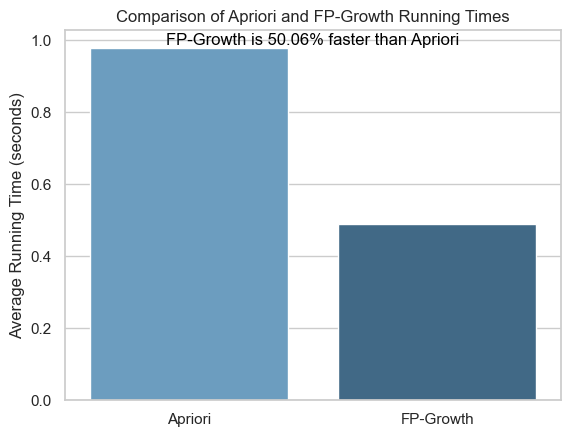

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14716\3447850408.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14716\3447850408.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
C:\Users\Lenov

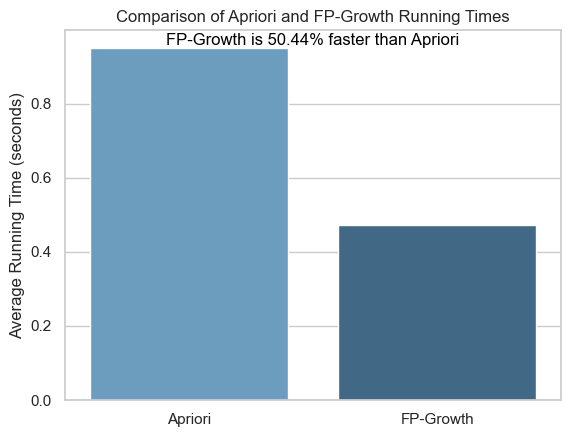

In [20]:
# Function to run the models multiple times and calculate the average duration
def compare_model_runtimes(num_runs=10):
    apriori_durations = []
    fpgrowth_durations = []

    for _ in range(num_runs):
        apriori_duration = generate_and_save_apriori_results_and_itemsets()
        fpgrowth_duration = generate_and_save_fpgrowth_results_and_itemsets()

        apriori_durations.append(apriori_duration)
        fpgrowth_durations.append(fpgrowth_duration)

    # Calculate average durations
    avg_apriori_duration = sum(apriori_durations) / num_runs
    avg_fpgrowth_duration = sum(fpgrowth_durations) / num_runs

    # Calculate the speed improvement percentage
    speed_improvement = ((avg_apriori_duration - avg_fpgrowth_duration) / avg_apriori_duration) * 100

    # Create a bar chart to show the differences
    models = ['Apriori', 'FP-Growth']
    avg_durations = [avg_apriori_duration, avg_fpgrowth_duration]

    plt.bar(models, avg_durations, color=['blue', 'blue'])
    plt.ylabel('Average Running Time (seconds)')
    plt.title('Comparison of Apriori and FP-Growth Running Times')

    # Display the percentage difference on the chart
    plt.text(0.5, max(avg_durations), f"{speed_improvement:.2f}% faster", ha='center', va='bottom', fontsize=12, color='black')
# Function to run the models multiple times and calculate the average duration
def compare_model_runtimes(num_runs=10):
    apriori_durations = []
    fpgrowth_durations = []

    for _ in range(num_runs):
        apriori_duration = generate_and_save_apriori_results_and_itemsets()
        fpgrowth_duration = generate_and_save_fpgrowth_results_and_itemsets()

        apriori_durations.append(apriori_duration)
        fpgrowth_durations.append(fpgrowth_duration)

    # Calculate average durations
    avg_apriori_duration = sum(apriori_durations) / num_runs
    avg_fpgrowth_duration = sum(fpgrowth_durations) / num_runs

    # Calculate the speed improvement percentage
    if avg_fpgrowth_duration < avg_apriori_duration:
        speed_improvement = ((avg_apriori_duration - avg_fpgrowth_duration) / avg_apriori_duration) * 100
        faster_model = f"FP-Growth is {speed_improvement:.2f}% faster than Apriori"
    else:
        speed_improvement = ((avg_fpgrowth_duration - avg_apriori_duration) / avg_fpgrowth_duration) * 100
        faster_model = f"Apriori is {speed_improvement:.2f}% faster than FP-Growth"

    # Create a bar chart with seaborn
    sns.set(style="whitegrid")
    models = ['Apriori', 'FP-Growth']
    avg_durations = [avg_apriori_duration, avg_fpgrowth_duration]

    # Create the bar plot
    ax = sns.barplot(x=models, y=avg_durations, palette="Blues_d")

    # Add labels and title
    ax.set_ylabel('Average Running Time (seconds)')
    ax.set_title('Comparison of Apriori and FP-Growth Running Times')

    # Display the percentage difference as text on the plot
    plt.text(0.5, max(avg_durations), faster_model, ha='center', va='bottom', fontsize=12, color='black')

    # Show the chart
    plt.show()

# Example usage
compare_model_runtimes(num_runs=10)
    # Show the chart
plt.show()

# Example usage
compare_model_runtimes(num_runs=10)

choose fpgrowth because it is faster and uses less memory...

## Rules

In [177]:
# Function to print rules clearly, sorted by lift in descending order
def print_rules(results, algorithm_name):
    print(f"\n{algorithm_name} Rules (sorted by Lift):\n")
    
    # Sort the dataframe by lift in descending order
    if 'lift' in results.columns:
        sorted_results = results.sort_values(by='lift', ascending=False)
    else:
        sorted_results = results
    
    for index, row in sorted_results.iterrows():
        antecedents = row['antecedents']
        consequents = row['consequents']
        support = row.get('support', 'N/A')  # Using 'N/A' if support is not present
        confidence = row.get('confidence', 'N/A')
        lift = row.get('lift', 'N/A')
        leverage = row.get('leverage', 'N/A')
        conviction = row.get('conviction', 'N/A')
        zhangs_metric = row.get('zhangs_metric', 'N/A')
        
        print(f"Rule {index + 1}:")
        print(f"  Antecedents: {antecedents}")
        print(f"  Consequents: {consequents}")
        print(f"  Support: {support}")
        print(f"  Confidence: {confidence}")
        print(f"  Lift: {lift}")
        print(f"  Leverage: {leverage}")
        print(f"  Conviction: {conviction}")
        print(f"  Zhang's Metric: {zhangs_metric}")
        print("-" * 40)

# Print the rules for FP-Growth results
print_rules(fpgrowth_results, "FP-Growth")


FP-Growth Rules (sorted by Lift):

Rule 19:
  Antecedents: soft wave kids curl gentle shampoo, soft wave kids curl gentle hair milk
  Consequents: soft wave kids curl gentle moisturizer
  Support: 0.0227182144280589
  Confidence: 0.890625
  Lift: 19.77502765486726
  Leverage: 0.0215693809182121
  Conviction: 8.731082389113478
  Zhang's Metric: 0.9742833566533922
----------------------------------------
Rule 15:
  Antecedents: soft wave kids strawberry conditioner over 90 natural origin ingredients
  Consequents: soft wave kids shampoo strawberry over 90 natural origin ingredients
  Support: 0.0267038660821044
  Confidence: 0.8170731707317073
  Lift: 17.826405090137857
  Leverage: 0.025205871060277
  Conviction: 5.216102032682342
  Zhang's Metric: 0.9757946977104588
----------------------------------------
Rule 20:
  Antecedents: soft wave kids curl gentle hair milk, soft wave kids curl gentle moisturizer
  Consequents: soft wave kids curl gentle shampoo
  Support: 0.0227182144280589
 

## Distribution of support, confidence, and lift

In [22]:
# Plot Support Distribution
plt.figure(figsize=(10, 6))
sns.histplot(fpgrowth_results['support'], bins=20, kde=True)
plt.title('Distribution of Support')
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('C:\\Users\\Lenovo\\Desktop\\support_distribution.png')
plt.close()

# Plot Confidence Distribution
plt.figure(figsize=(10, 6))
sns.histplot(fpgrowth_results['confidence'], bins=20, kde=True)
plt.title('Distribution of Confidence')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('C:\\Users\\Lenovo\\Desktop\\confidence_distribution.png')
plt.close()

# Plot Lift Distribution
plt.figure(figsize=(10, 6))
sns.histplot(fpgrowth_results['lift'], bins=20, kde=True)
plt.title('Distribution of Lift')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('C:\\Users\\Lenovo\\Desktop\\lift_distribution.png')
plt.close()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

## Product Categories Analysis

In [31]:
def plot_category_distribution(df_expanded, fpgrowth_results, file_path):
    # Extract the individual items from antecedents and consequents
    itemsets = fpgrowth_results['antecedents'].apply(lambda x: x.split(', ')).explode()

    # Strip any leading/trailing whitespaces from product names in df_expanded
    df_expanded['product_name'] = df_expanded['product_name'].str.strip()

    # Merge the itemsets with the expanded DataFrame to get the categories
    merged_df = pd.merge(itemsets.to_frame(name='product_name'), df_expanded, on='product_name', how='left')

    # Debugging: Print the merged DataFrame to see if the merge was successful
    print("\nMerged DataFrame sample:")
    print(merged_df.head())

    # Check if the merge resulted in an empty DataFrame
    if merged_df.empty:
        print("Merged DataFrame is empty. Ensure that the itemsets match product names in df_expanded.")
        return

    # Calculate the frequency of each category in the frequent itemsets
    category_distribution = merged_df['product_category'].value_counts()

    # Check if the category distribution is empty
    if category_distribution.empty:
        print("No categories found in the frequent itemsets.")
        return

    # Plotting the distribution of product categories within the frequent itemsets
    plt.figure(figsize=(12, 8))
    category_distribution.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Product Categories in Frequent Itemsets')
    plt.xlabel('Product Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Category distribution plot saved to {file_path}")

# Example usage:
plot_category_distribution(df_expanded, fpgrowth_results, 'C:\\Users\\Lenovo\\Desktop\\category_distribution.png')



Merged DataFrame sample:
                                        product_name operating_unit_name  \
0  cosmal cure professional fall control balsam f...     Cosmaline Local   
1  cosmal cure professional fall control balsam f...     Cosmaline Local   
2  cosmal cure professional fall control balsam f...     Cosmaline Local   
3  cosmal cure professional fall control balsam f...     Cosmaline Local   
4  cosmal cure professional fall control balsam f...     Cosmaline Local   

  ecom_reference_order_number ordered_item  ordered_quantity  \
0                      400950       197055                 1   
1                      400950       197055                 1   
2                      400950       197055                 1   
3                      400493       197055                 2   
4                      400493       197055                 2   

   unit_selling_price  unit_list_price ordered_date         tax_code  \
0              1.7115           1.7115   2024-03-11  REVENUE